In [1]:
from sklearn.metrics import rand_score, silhouette_score, confusion_matrix, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import gower
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.optimize import linear_sum_assignment
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from scipy.spatial.distance import euclidean, pdist, squareform

In [2]:
file_path = 'data_preprocessed.csv'
data = pd.read_csv(file_path)
data = data.dropna()

numerical_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss']  
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']  
sorted_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

y = pd.get_dummies(data['income'], drop_first=True)
y = y.values.reshape(-1)
X = data.drop('income', axis=1)


X = X[sorted_columns]

X, _, y, _ = train_test_split(X, y, train_size=500, stratify=y, random_state=42)

In [3]:
X

,age,fnlwgt,hours-per-week,capital-gain,capital-loss,workclass,education,marital-status,occupation,relationship,race,sex,native-country
46469,1.699726,-1.336440,1.169900,-0.236090,-0.218916,Self-emp-not-inc,Doctorate,Married-civ-spouse,Prof-specialty,Husband,White,Male,USA
25945,0.033580,1.201977,1.169900,-0.236090,-0.218916,Local-gov,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,USA
17367,0.715186,-0.457879,-0.078962,-0.236090,-0.218916,Private,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,USA
35930,-0.875227,2.422975,-0.078962,-0.236090,-0.218916,Private,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,USA
30867,-0.496557,-0.438035,-0.328734,-0.236090,-0.218916,Private,10th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41939,-0.420823,-0.589286,-0.078962,3.122535,-0.218916,Private,Bachelors,Never-married,Sales,Not-in-family,White,Male,USA
23145,0.185048,-0.262294,-0.078962,-0.236090,5.551940,Private,HS-grad,Divorced,Craft-repair,Not-in-family,White,Male,USA
29314,-0.799493,-0.000380,0.753612,-0.236090,-0.218916,State-gov,Some-college,Separated,Adm-clerical,Unmarried,White,Female,USA
18548,-1.102428,-0.363713,-0.911536,-0.236090,-0.218916,Private,HS-grad,Never-married,Machine-op-inspct,Other-relative,Black,Female,USA


In [4]:
gower_dist = gower.gower_matrix(X, cat_features = [False]*len(numerical_columns)+[True]*len(categorical_columns))
gower_dist

array([[0.        , 0.42385945, 0.26233953, ..., 0.5103906 , 0.605644  ,
        0.26072782],
       [0.42385945, 0.        , 0.4160798 , ..., 0.40782443, 0.4302647 ,
        0.4914425 ],
       [0.26233953, 0.4160798 , 0.        , ..., 0.4946807 , 0.4971506 ,
        0.16450766],
       ...,
       [0.5103906 , 0.40782443, 0.4946807 , ..., 0.        , 0.48397878,
        0.49312034],
       [0.605644  , 0.4302647 , 0.4971506 , ..., 0.48397878, 0.        ,
        0.42183924],
       [0.26072782, 0.4914425 , 0.16450766, ..., 0.49312034, 0.42183924,
        0.        ]], dtype=float32)

In [5]:
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=42)
X_mds = mds.fit_transform(gower_dist)

X_mds

            age    fnlwgt  hours-per-week  capital-gain  capital-loss  \
46469  1.699726 -1.336440        1.169900      -0.23609     -0.218916   
25945  0.033580  1.201977        1.169900      -0.23609     -0.218916   
17367  0.715186 -0.457879       -0.078962      -0.23609     -0.218916   
35930 -0.875227  2.422975       -0.078962      -0.23609     -0.218916   
30867 -0.496557 -0.438035       -0.328734      -0.23609     -0.218916   

              workclass  education         marital-status       occupation  \
46469  Self-emp-not-inc  Doctorate     Married-civ-spouse   Prof-specialty   
25945         Local-gov    Masters          Never-married   Prof-specialty   
17367           Private    Masters     Married-civ-spouse  Exec-managerial   
35930           Private  Bachelors          Never-married     Adm-clerical   
30867           Private       10th  Married-spouse-absent    Other-service   

        relationship   race     sex native-country  
46469        Husband  White    Male    

array([[ 0.26180204,  0.16520514, -0.00533979],
       [-0.17512354,  0.26744332, -0.12412267],
       [ 0.15936471,  0.04413865,  0.04874126],
       ...,
       [-0.11284763,  0.11138292, -0.32449569],
       [-0.26465149, -0.24789193, -0.01193986],
       [ 0.15959004, -0.01864562,  0.0808787 ]])

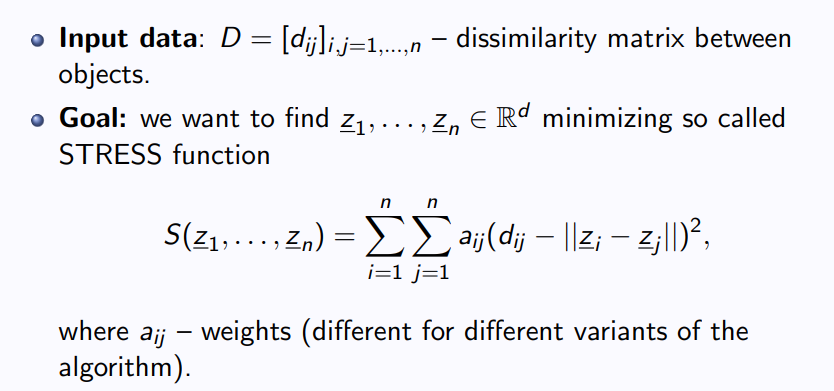

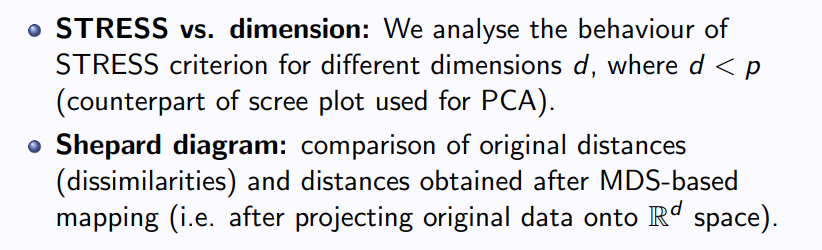

STRESS: 722.8422199071672 722.9661332675772


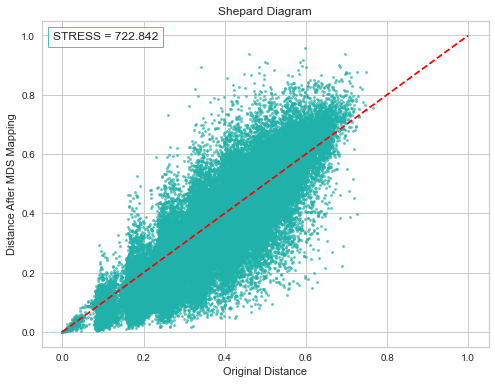

In [6]:
dist_mds_k2 = squareform(pdist(X_mds, metric='euclidean'))

# STRESS criterion
dis_original = gower_dist
STRESS = 0.5 * np.sum((dis_original - dist_mds_k2) ** 2)
stress_sk = mds.stress_
print(f'STRESS: {STRESS}',stress_sk )

# Shepard diagram
plt.figure(figsize=(8, 6))

plt.scatter(dis_original, dist_mds_k2, s=5, c='lightseagreen', alpha=0.5)
plt.plot([0, 1], color='red', linestyle='dashed')
plt.title('Shepard Diagram')
plt.xlabel('Original Distance')
plt.ylabel('Distance After MDS Mapping')
legend = plt.legend([f'STRESS = {STRESS:.3f}'], loc='upper left', 
                    frameon=True, fancybox=False, handletextpad=0,  handlelength=0,fontsize=12 )
frame = legend.get_frame()
frame.set_edgecolor('lightseagreen')
frame.set_linewidth(1)
plt.show()

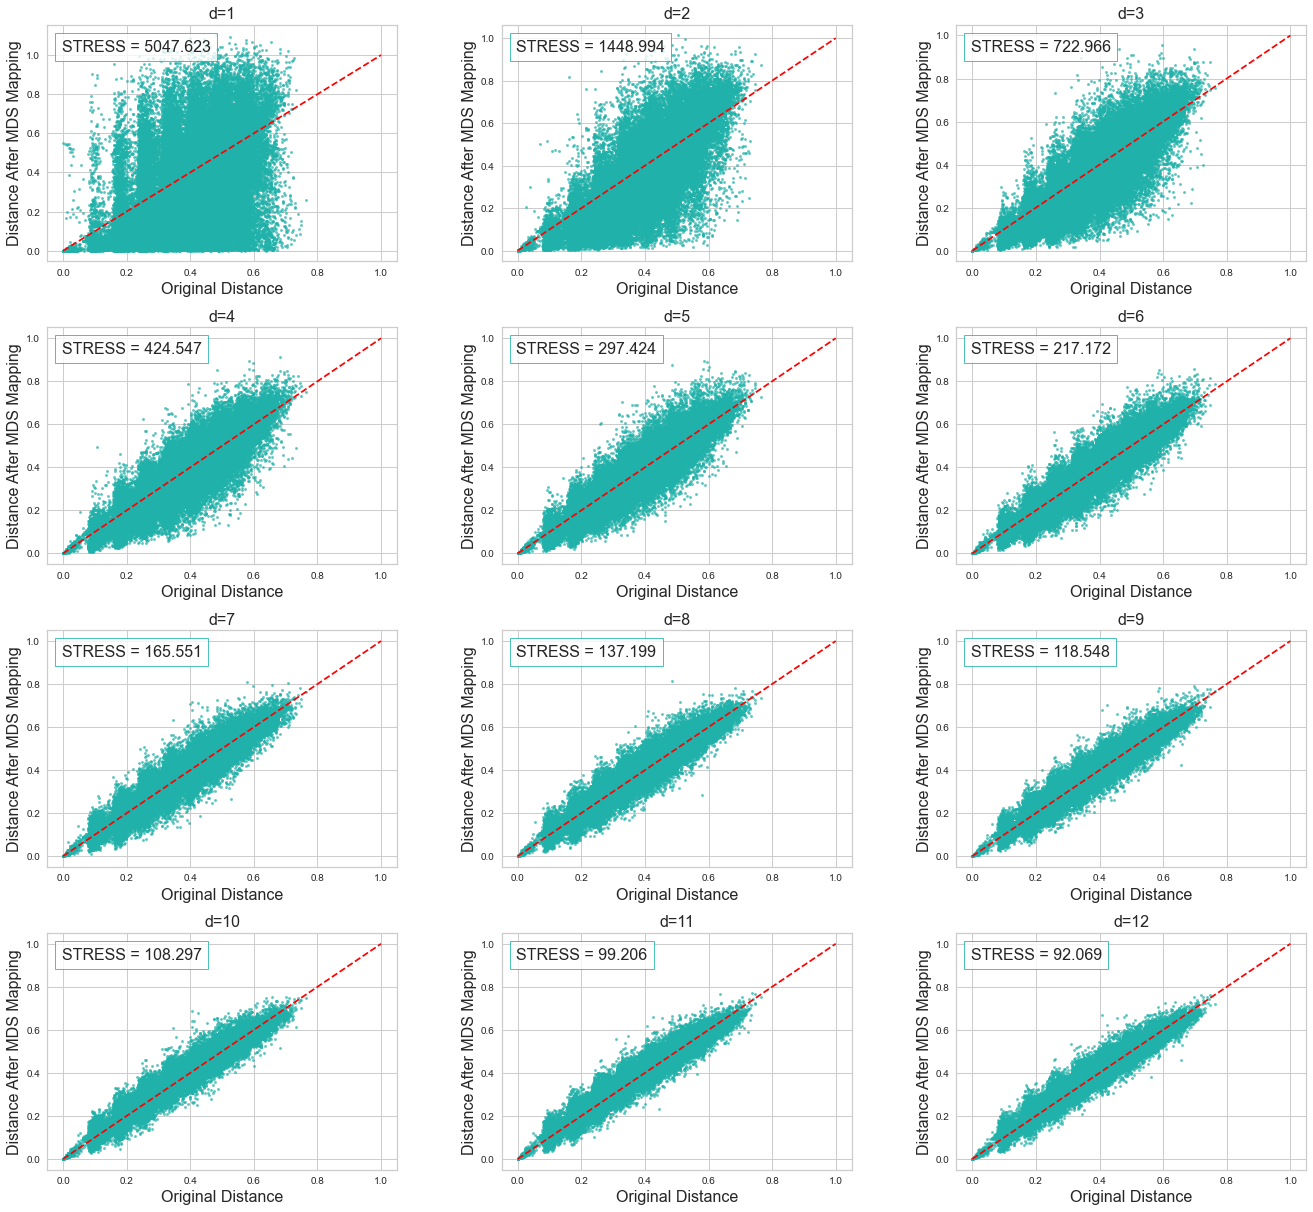

In [8]:
d_max = 12
stress_vec = np.zeros(d_max)

fig, axs = plt.subplots(4, 3, figsize=(19, 17))
axs = axs.ravel()

for d in range(1, d_max + 1):
    mds = MDS(n_components=d, dissimilarity="precomputed", random_state=42)
    mds_k = mds.fit_transform(gower_dist)
    
    dist_mds_k = squareform(pdist(mds_k, metric='euclidean'))
    
    # STRESS criterion
    dis_original = gower_dist
    STRESS = mds.stress_
    stress_vec[d-1] = STRESS
    
    # Shepard diagram
    axs[d-1].scatter(dis_original, dist_mds_k, s=5, c='lightseagreen', alpha=0.5)
    axs[d-1].plot([0, 1], color='red', linestyle='dashed')
    axs[d-1].set_title(f'd={d}',fontsize=16)
    axs[d-1].set_xlabel('Original Distance',fontsize=16)
    axs[d-1].set_ylabel('Distance After MDS Mapping',fontsize=16)
    legend = axs[d-1].legend([f'STRESS = {STRESS:.3f}'], loc='upper left', 
                    frameon=True, fancybox=False, handletextpad=0,  handlelength=0,fontsize=16)
    frame = legend.get_frame()
    frame.set_edgecolor('lightseagreen')
    frame.set_linewidth(1)
    axs[d-1].grid(True)
    
plt.subplots_adjust(wspace=3, hspace=3)
plt.tight_layout()
plt.savefig("Dimension_reduction\stress_MDS.jpg", bbox_inches='tight')
plt.show()

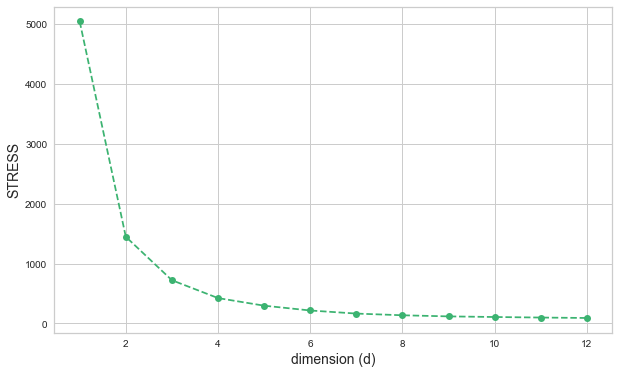

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, d_max + 1), stress_vec, marker='o', linestyle='--', color='mediumseagreen')
plt.xlabel('dimension (d)',fontsize=14 )
plt.ylabel('STRESS',fontsize=14 )
plt.grid(True)
plt.savefig("Dimension_reduction\stress_dimension_relation.jpg", bbox_inches='tight')
plt.show()

## FAMD

In [46]:
pip install prince

Note: you may need to restart the kernel to use updated packages.


In [183]:
import prince

In [184]:
famd = prince.FAMD(
    n_components=13,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn")  # same parameter as sklearn.preprocessing.OneHotEncoder

f_X = famd.fit(X)

In [185]:
famd.row_coordinates(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.022124,0.566674,-0.721957,-0.589041,0.615901,0.434157,-0.377841,0.903813,-0.649839,-0.202061,-0.008983,0.716068,-0.067116
1,0.213674,0.321847,-1.694674,0.834881,0.085065,-1.594148,-0.416317,0.663899,-0.293767,0.432797,0.569218,-0.108265,-0.167928
2,-0.331998,0.033671,0.101916,0.084591,-0.376405,0.259956,-0.219851,-0.701587,-0.690495,-0.148915,-0.803823,0.371730,0.254193
3,0.372562,0.033989,0.149203,0.755313,-0.644355,-0.757819,0.161559,-0.548751,0.279961,-0.587375,-0.635564,-0.428717,-0.725609
4,-0.745733,0.034434,1.136092,0.748475,-0.031624,0.467704,0.985394,1.476201,1.629458,0.395363,-0.119800,-1.060731,0.363545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,-0.744138,-0.003766,0.578125,-0.216985,0.158733,-0.117299,-0.262681,0.786784,-0.684899,0.286668,-0.260364,-0.342697,0.131939
48837,-0.403924,0.175250,-0.239214,0.457533,0.014766,0.970335,-0.407329,0.700016,-0.544570,0.528083,-0.665032,-0.083791,0.426432
48839,0.483881,-0.193589,1.659885,0.351447,-0.562666,-0.212143,-0.324033,0.875717,-0.051845,0.412350,-0.475112,-0.280886,0.186395
48840,0.467011,1.299546,-0.624290,-0.336361,1.286698,0.376448,0.915426,0.290650,0.269323,-0.043958,0.109861,0.659395,-0.110471


In [174]:
file_path = 'data_preprocessed.csv'
data = pd.read_csv(file_path)
data = data.dropna()

numerical_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss']  
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']  
sorted_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

y = pd.get_dummies(data['income'], drop_first=True)
y = y.values.reshape(-1)
X = data.drop('income', axis=1)


In [175]:
X.shape

(46033, 13)

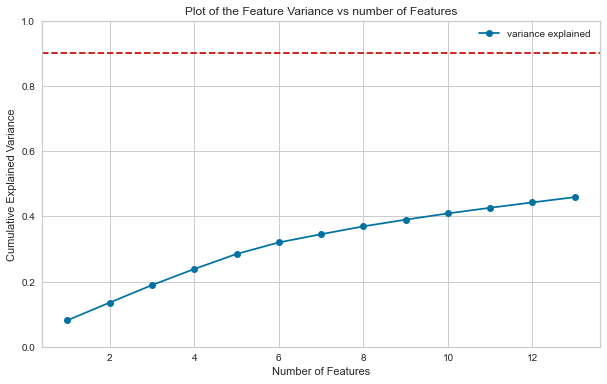

In [176]:
famd = prince.FAMD(
    n_components=13,  
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn"
)
X_famd = famd.fit(X)
explained_inertia = famd.explained_inertia_


cumulative_inertia = np.cumsum(explained_inertia)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_inertia) + 1), cumulative_inertia, marker='o', linestyle='-', color='b',label='variance explained')
plt.axhline(y=0.9, color='r', linestyle='--')

plt.title('Plot of the Feature Variance vs number of Features')
plt.xlabel('Number of Features')
plt.ylim(0,1)
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.show()

In [177]:
famd.explained_inertia_.sum()

0.45878371485319136

In [146]:
X_famd.cumulative_percentage_of_variance_

AttributeError: 'FAMD' object has no attribute 'cumulative_percentage_of_variance_'

In [162]:
famd = prince.FAMD(
    n_components=13,  
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42
)
X_famd = famd.fit(X)

In [163]:
famd.transform(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.022124,0.566674,-0.721957,-0.589041,0.615901,0.434157,-0.377841,0.903813,-0.649839,-0.202061,-0.008983,0.716068,-0.067116
1,0.213674,0.321847,-1.694674,0.834881,0.085065,-1.594148,-0.416317,0.663899,-0.293767,0.432797,0.569218,-0.108265,-0.167928
2,-0.331998,0.033671,0.101916,0.084591,-0.376405,0.259956,-0.219851,-0.701587,-0.690495,-0.148915,-0.803823,0.371730,0.254193
3,0.372562,0.033989,0.149203,0.755313,-0.644355,-0.757819,0.161559,-0.548751,0.279961,-0.587375,-0.635564,-0.428717,-0.725609
4,-0.745733,0.034434,1.136092,0.748475,-0.031624,0.467704,0.985394,1.476201,1.629458,0.395363,-0.119800,-1.060731,0.363545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,-0.744138,-0.003766,0.578125,-0.216985,0.158733,-0.117299,-0.262681,0.786784,-0.684899,0.286668,-0.260364,-0.342697,0.131939
48837,-0.403924,0.175250,-0.239214,0.457533,0.014766,0.970335,-0.407329,0.700016,-0.544570,0.528083,-0.665032,-0.083791,0.426432
48839,0.483881,-0.193589,1.659885,0.351447,-0.562666,-0.212143,-0.324033,0.875717,-0.051845,0.412350,-0.475112,-0.280886,0.186395
48840,0.467011,1.299546,-0.624290,-0.336361,1.286698,0.376448,0.915426,0.290650,0.269323,-0.043958,0.109861,0.659395,-0.110471
